In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import print_function
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from datetime import datetime
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'
pd.set_option("max_columns",50)

In [2]:
%%time
train = pd.read_csv("../data/train_2013.csv", index_col=0)
train = train.reset_index(drop=True)
np.random.seed(402)
train = train.ix[np.random.choice(train.index, 50000)]
train = train.reset_index(drop=True)

test = pd.read_csv("../data/test.csv")
test_id = test["id"]

Wall time: 52.4 s


### Random forest를 통해 유의미한 Feature 8개 설정 ( h2o.ai도 사용함 ) => 그대로 결과물 제출

In [40]:
# use_col = ["is_booking", "user_id", "date_time","user_location_country","orig_destination_distance", "srch_co","srch_ci","user_location_region",\
#                "hotel_market","srch_destination_id","hotel_cluster"]

In [61]:
train.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster'],
      dtype='object')

In [62]:
test.columns # id가 생기고 hotel_cluster / is_booking / cnt 가 사라짐

Index([u'id', u'date_time', u'site_name', u'posa_continent',
       u'user_location_country', u'user_location_region',
       u'user_location_city', u'orig_destination_distance', u'user_id',
       u'is_mobile', u'is_package', u'channel', u'srch_ci', u'srch_co',
       u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt',
       u'srch_destination_id', u'srch_destination_type_id', u'hotel_continent',
       u'hotel_country', u'hotel_market'],
      dtype='object')

In [3]:
use_col2 = ["user_id", "date_time","user_location_country","orig_destination_distance", "srch_co","srch_ci","user_location_region",\
               "hotel_market","srch_destination_id"]

In [4]:
train_y = train[["hotel_cluster"]]
train = train[use_col2]
test = test[use_col2]

In [5]:
%%time
le = preprocessing.LabelEncoder()
# train.fillna(0)
# test.fillna(0)

train["date_time"] = pd.to_datetime(train["date_time"], errors="coerce")
train["date_time"] = train["date_time"].dt.date
train["srch_ci"] = pd.to_datetime(train["srch_ci"], errors="coerce")
train["srch_co"] = pd.to_datetime(train["srch_co"], errors="coerce")

train["date_time"] = le.fit_transform(train["date_time"])
train["srch_ci"] = le.fit_transform(train["srch_ci"])
train["srch_co"] = le.fit_transform(train["srch_co"])

train["orig_destination_distance"].fillna(0, inplace=True)

test["date_time"] = pd.to_datetime(test["date_time"], errors="coerce")
test["date_time"] = test["date_time"].dt.date
test["srch_ci"] = pd.to_datetime(test["srch_ci"], errors="coerce")
test["srch_co"] = pd.to_datetime(test["srch_co"], errors="coerce")

test["date_time"] = le.fit_transform(test["date_time"])
test["srch_ci"] = le.fit_transform(test["srch_ci"])
test["srch_co"] = le.fit_transform(test["srch_co"])

test["orig_destination_distance"].fillna(0, inplace=True)

C:\Users\Byeon\Anaconda3\envs\py27\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: In the future, NAT != NAT will be True rather than False.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Wall time: 16.3 s


In [12]:
model = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=-1, random_state=777)

In [16]:
%%time

print('='*50)
print('# Test shape : {}'.format(test.shape))

model.fit(train,train_y)

preds = model.predict_proba(test)
preds = np.fliplr(np.argsort(preds, axis=1))


# Test shape : (2528243, 9)
Wall time: 6min 46s


In [32]:
preds[:,:5]

array([[64,  5, ..., 25, 11],
       [62, 78, ..., 82, 64],
       ..., 
       [91, 48, ..., 41, 32],
       [82, 30, ..., 58, 62]], dtype=int64)

In [49]:
result_df = pd.DataFrame([ " ".join(row) for row in preds[:,:5].astype(str)])

In [57]:
result_df = result_df.rename(index=str, columns={0:"hotel_cluster"})

In [72]:
result_df = result_df.reset_index()
result_df = result_df.rename(index=str,columns={"index":"id"})

In [81]:
result_df1 = pd.read_csv("201702061420.csv", index_col="id").drop(["Unnamed: 0"], axis=1)

In [83]:
result_df1.to_csv("201702061422.csv")


In [86]:
result_df1.tail()

,hotel_cluster
id,
2528238,26 84 73 0 96
2528239,58 82 78 30 61
2528240,1 45 79 88 24
2528241,91 48 42 41 32
2528242,82 30 67 58 62


public score = 0.14201

In [110]:
print("="*20)

trn_x1 = train
trn_y1 = train_y

#     model = RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=402)

#     model.fit(trn_x1,trn_y1)

importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
rank_series = pd.Series([])
for f in range(trn_x1.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], trn_x1.columns[indices[f]], importances[indices[f]]))

#         rank_series = rank_series.append(pd.Series([trn_x1.columns[indices[f]], importances[indices[f]]]))

#     rank_df2.insert(len(rank_df2.columns), column=i ,value=rank_series)

plt.title("Feature importances")
plt.bar(range(trn_x1.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(trn_x1.shape[1]), indices)
plt.xlim([-1, trn_x1.shape[1]])
plt.show()


아래 feature 사용

https://www.kaggle.com/jwegas/expedia-hotel-recommendations/randomforest-test-20160418/run/210428/code

In [2]:
%%time
train = pd.read_csv("../data/train_2013.csv", index_col=0)
train = train.reset_index(drop=True)
np.random.seed(402)
train = train.ix[np.random.choice(train.index, 50000)]
train = train.reset_index(drop=True)

print("resd the train.csv")
use_col3 = ['site_name', 'user_location_region', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'hotel_market', 'hotel_country']
train_y = train[["hotel_cluster"]]
train = train[use_col3]
print("read the test.csv")
test = pd.read_csv("../data/test.csv")
test = test[use_col3]

print("modeling strart")
model = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=-1, random_state=777)
print('='*50)
print('# Test shape : {}'.format(test.shape))

model.fit(train,train_y)

preds = model.predict_proba(test)
preds = np.fliplr(np.argsort(preds, axis=1))

result_df = pd.DataFrame([ " ".join(row) for row in preds[:,:5].astype(str)], columns=["hotel_cluster"])
result_df.index.names = ["id"]
file_name = datetime.now().strftime("result_%Y%m%d%H%M%S") + '.csv'
result_df.to_csv(os.path.join('../output',file_name), index=True)

Wall time: 43.9 s


## public score = 0.15316

Feature ranking:
1. feature 6 hotel_market (0.325721)
2. feature 7 hotel_country (0.310161)
3. feature 5 srch_destination_id (0.194103)
4. feature 1 user_location_region (0.050452)
5. feature 2 is_package (0.040391)
6. feature 0 site_name (0.033722)
7. feature 3 srch_adults_cnt (0.024316)
8. feature 4 srch_children_cnt (0.021133)


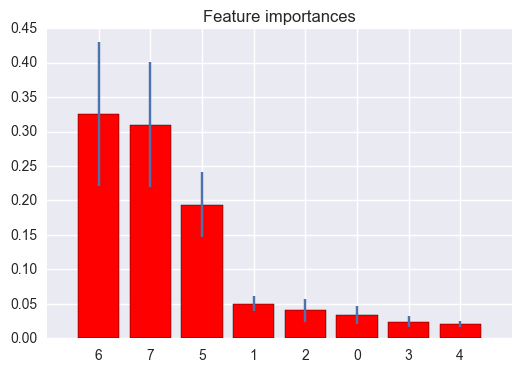

In [8]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(train.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], train.columns[indices[f]], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()


In [38]:
%%time
train = pd.read_csv("../data/train_2013.csv", index_col=0)
train = train.reset_index(drop=True)
train = train[train["is_booking"] == 1]
np.random.seed(402)
train = train.ix[np.random.choice(train.index, 50000)]
train = train.reset_index(drop=True)


Wall time: 7.68 s


In [2]:
%%time
train = pd.read_csv("../data/train_2013.csv", index_col=0)
train = train.reset_index(drop=True)
train = train[train["is_booking"] == 1]
np.random.seed(402)
train = train.ix[np.random.choice(train.index, 50000)]
train = train.reset_index(drop=True)

print("read the train.csv")
use_col3 = ['site_name', 'user_location_region', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'hotel_market', 'hotel_country']
train_y = train[["hotel_cluster"]]
train = train[use_col3]
print("read the test.csv")
test = pd.read_csv("../data/test.csv")
test = test[use_col3]

print("modeling strart")
model = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=-1, random_state=777)
print('='*50)
print('# Test shape : {}'.format(test.shape))

model.fit(train,train_y)

preds = model.predict_proba(test)
preds = np.fliplr(np.argsort(preds, axis=1))

result_df = pd.DataFrame([ " ".join(row) for row in preds[:,:5].astype(str)], columns=["hotel_cluster"])
result_df.index.names = ["id"]
file_name = datetime.now().strftime("result_%Y%m%d%H%M%S") + '.csv'
print("save file")
result_df.to_csv(os.path.join('../output',file_name), index=True)

read the train.csv
read the test.csv
modeling strart
# Test shape : (2528243, 8)


C:\Users\Byeon\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Wall time: 11min 58s



## result_20170206155850.csv => 0.15218 
## is_booking == 1 인 친구들 기반

In [6]:
train.head()

,site_name,user_location_region,is_package,srch_adults_cnt,srch_children_cnt,srch_destination_id,hotel_market,hotel_country
0,2,331,0,1,0,12696,122,8
1,2,321,0,2,0,12189,637,50
2,2,348,0,1,0,2758,1916,31
3,2,315,0,4,2,8267,675,50
4,2,348,0,1,0,18741,462,50
